# Introduction à la librairie Keras

Dans le TP précédent, vous avez implémenté l'apprentissage et l'inférence d'un réseau de neurones. En pratique, il est plus courant de faire appel à des librairies qui masquent la complexité de ces algorithmes (notamment le calcul des gradients, réalisé par différentiation automatique). Dans la suite, nous utiliserons pour les TPs la librairie ***Keras***. Dans un premier temps, pour ce TP nous allons détailler sur un exemple simple (le même que pour le TP précédent) les différentes étapes à mettre en place pour entraîner un réseau à l'aide de cette librairie.

Le bloc de code ci-dessous sera utile pour analyser l'évolution des performances au cours de l'apprentissage

In [ ]:
def plot_training_analysis(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  #plt.figure()
  plt.subplots(1, 2, figsize=(10, 4))


  plt.subplot(1,2,1)
  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()



## Exemple de classification binaire simple



Chargement des données (ce sont les mêmes que lors du dernier TP)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

# Génération des données
x, y = datasets.make_blobs(n_samples=250, n_features=2, centers=2, center_box=(- 3, 3), random_state=1)
# Partitionnement des données en apprentissage et test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

# Affichage des données d'apprentissage
plt.plot(x_train[y_train==0,0], x_train[y_train==0,1], 'b.', label='Apprentissage, classe 0')
plt.plot(x_train[y_train==1,0], x_train[y_train==1,1], 'r.', label='Apprentissage, classe 1')

plt.xlabel('x1')
plt.ylabel('x2')

# Affichage des données de test
plt.plot(x_test[y_test==0,0], x_test[y_test==0,1], 'b+', label='Test, classe 0')
plt.plot(x_test[y_test==1,0], x_test[y_test==1,1], 'r+', label='Test, classe 1')

plt.legend()
plt.show()

Dans ce problème, les données $x^{(i)}$ sont les points, on a donc $x^{(i)} \in \mathbb{R}^2$. Les étiquettes $y^{(i)}$ correspondent à la couleur des points (bleue ou rouge), matérialisée par un label (0 ou 1).

Pour résoudre le problème, on peut donc construire un perceptron monocouche à 2 entrées et une sortie.

<center>
<img src="https://drive.google.com/uc?id=1WfUL0fTE7fjeHMrlGjgH3b_3511ttnO8">
</center>

Il s'agit d'un problème de classification binaire, il faut donc utiliser une fonction d'activation **sigmoide** sur la couche de sortie.

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Définition du modèle, un simple perceptron monocouche.
model = Sequential() # Dans un modèle séquentiel, on peut ajouter les couches les unes après les autres
# Ici, on définit une seule couche connectant 2 neurones d'entrée à un neurone de sortie, portant une activation sigmoide
model.add(Dense(1, activation='sigmoid', input_dim=2)) # input_dim indique la dimension de la couche d'entrée, ici 2

model.summary() # affiche un résumé du modèle

Le résumé du modèle (*summary*) nous indique le nombre de paramètres du modèle, ici 3 : 2 poids synaptiques et un biais.

Il nous faut maintenant choisir la fonction de coût : pour ce problème de classification binaire, le choix standard est l'entropie croisée binaire (*binary cross-entropy*).

On choisit dans un premier temps un optimiseur standard, la descente de gradient stochastique.


In [ ]:
from tensorflow.keras import optimizers

# Définition de l'optimiseur
sgd = optimizers.SGD(learning_rate=0.1) # On choisit la descente de gradient stochastique, avec un taux d'apprentissage de 0.1

# On définit ici, pour le modèle introduit plus tôt, l'optimiseur choisi (la SGD), la fonction de perte (ici
# l'entropie croisée binaire pour un problème de classification binaire) et les métriques que l'on veut observer pendant
# l'entraînement. L'accuracy désigne le pourcentage de bonnes classification, et est un indicateur plus simple à interpréter que l'entropie croisée.
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entraînement du modèle avec des mini-batchs de taille 20, sur 15 epochs.
# Le paramètre validation_split signifie qu'on tire aléatoirement une partie des données
# (ici 20%) pour servir d'ensemble de validation
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=20)

plot_training_analysis(history)

L'apprentissage semble bien se passer : la perte d'apprentissage et la perte de validation décroissent au cours du temps, et l'accuracy est proche de 100% à la fin de l'apprentissage.

La cellule suivante introduit une fonction permettant de visualiser la frontière de décision du modèle appris.

In [ ]:
import numpy as np
def print_decision_boundaries(model, x, y):
  dx, dy = 0.1, 0.1
  y_grid, x_grid = np.mgrid[slice(np.min(x[:,1]), np.max(x[:,1]) + dy, dy),
                  slice(np.min(x[:,0]), np.max(x[:,0]) + dx, dx)]


  x_gen = np.concatenate((np.expand_dims(np.reshape(x_grid, (-1)),1),np.expand_dims(np.reshape(y_grid, (-1)),1)), axis=1)
  z_gen = model.predict(x_gen).reshape(x_grid.shape)

  z_min, z_max = 0, 1

  c = plt.pcolor(x_grid, y_grid, z_gen, cmap='RdBu', vmin=z_min, vmax=z_max)
  plt.colorbar(c)
  plt.plot(x[y==0,0], x[y==0,1], 'r.')
  plt.plot(x[y==1,0], x[y==1,1], 'b.')
  plt.show()

In [ ]:
print_decision_boundaries(model, x_train, y_train)

## Exemple de classification plus "complexe"

Les données de la section précédente sont linéairement séparables : un séparateur linéaire suffit à obtenir des bonnes performances, et un perceptron monocouche est donc bien adapté à la résolution de ce problème.

Traitons maintenant un second problème légèrement plus
complexe, non linéairement séparable.

In [ ]:
x, y = datasets.make_gaussian_quantiles(n_samples=250, n_features=2, n_classes=2, random_state=1)
# Partitionnement des données en apprentissage et test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

# Affichage des données d'apprentissage
plt.plot(x_train[y_train==0,0], x_train[y_train==0,1], 'b.', label='Apprentissage, classe 0')
plt.plot(x_train[y_train==1,0], x_train[y_train==1,1], 'r.', label='Apprentissage, classe 1')

# Affichage des données de test
plt.plot(x_test[y_test==0,0], x_test[y_test==0,1], 'b+', label='Test, classe 0')
plt.plot(x_test[y_test==1,0], x_test[y_test==1,1], 'r+', label='Test, classe 1')

plt.xlabel('x1')
plt.ylabel('x2')

plt.legend()
plt.show()

**Travail à faire** : commencez par tester un perceptron monocouche comme nous l'avons vu précédemment.

Un perceptron monocouche ne permet que d'obtenir un séparateur linéaire, ce qui n'est pas suffisant pour apprendre à séparer ces données. La **capacité** du modèle est trop faible, et on est dans une situation de **sous-apprentissage** : la perte d'apprentissage ne diminue pas suffisamment, le modèle n'arrive pas à apprendre correctement l'ensemble d'apprentissage.

Pour résoudre ce problème, il faut ajouter (au moins) une couche cachée au modèle. Voici un exemple ci-dessous, où l'on ajoute une couche cachée à 2 neurones.

**Travail à faire** : testez l'entraînement de ce modèle, et au besoin ajustez le nombre de neurones de la couche cachée pour obtenir de bons résultats.

**Travail à faire** : testez également de remplacer l'optimiseur SGD par l'optimiseur [Adam](https://keras.io/api/optimizers/adam/)

## Sur-apprentissage et régularisation

Dans cette section, nous commençons par altérer un peu les données afin qu'elles comportent du "bruit" : la frontière de décision entre données bleues et rouges n'est plus si claire.

In [ ]:
x, y = datasets.make_gaussian_quantiles(n_samples=250, n_features=2, n_classes=2, random_state=1)
x[y==0] = x[y==0]*1.2
x[y==1] = x[y==1]*0.8

# Partitionnement des données en apprentissage et test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

# Affichage des données d'apprentissage
plt.plot(x_train[y_train==0,0], x_train[y_train==0,1], 'b.', label='Apprentissage, classe 0')
plt.plot(x_train[y_train==1,0], x_train[y_train==1,1], 'r.', label='Apprentissage, classe 1')

# Affichage des données de test
plt.plot(x_test[y_test==0,0], x_test[y_test==0,1], 'b+', label='Test, classe 0')
plt.plot(x_test[y_test==1,0], x_test[y_test==1,1], 'r+', label='Test, classe 1')

plt.xlabel('x1')
plt.ylabel('x2')

plt.legend()

plt.show()

**Travail à faire** : Reprenez le modèle à une couche cachée construit précédemment et vérifiez que ce modèle arrive toujours à apprendre une solution satisfaisante.

L'avantage de ce modèle à une couche cachée est qu'il reste assez simple : il n'a pas une capacité suffisante pour chercher à expliquer à tout prix la distribution des données d'apprentissage. L'accuracy plafonne vers 75% sur l'ensemble d'apprentissage, ce qui semble évoquer du sous-apprentissage, mais en réalité le modèle est satisfaisant car l'accuracy de validation est elle autour de 70%.


Une piste d'amélioration pourrait consister à augmenter la capacité du modèle afin d'obtenir de meilleures performances sur l'ensemble d'apprentissage.

**Travail à faire** : Augmentez la capacité du modèle (nombre de couches cachées, nombre de neurones par couche) de sorte d'obtenir une accuracy d'apprentissage d'environ 90%. Qu'observez-vous sur l'accuracy de validation ?

On observe du **sur-apprentissage** ! L'accuracy d'entrainement est élevée, mais l'accuracy de validation est faible. On doit alors chercher à limiter le sur-apprentissage, et pour ce faire on peut utiliser des techniques de régularisation. Une des techniques vues en cours consiste à appliquer une pénalité sur la norme des paramètres du modèle. Ainsi, plutôt que de minimiser une fonction objectif $J(\theta)$ classique :
$$ J(\theta) = \frac{1}{n} \sum_{i=1}^{n} \text{loss}(y^{(i)}, \hat{y}^{(i)}) $$

on minimise plutôt :
$$ J(\theta) = \frac{1}{n} \sum_{i=1}^{n} \text{loss}(y^{(i)}, \hat{y}^{(i)}) + \lambda \sum_{j=1}^M \theta_j^2 $$

où $M$ désigne le nombre de paramètres (poids synaptiques et biais) du réseau, $\theta$ désigne les paramètres du réseau.

En pratique il suffit d'appliquer cette pénalisation aux poids synaptiques seuls (car ils sont beaucoup plus nombreux).

La librairie Keras permet d'appliquer de la régularisation à n'importe quelle couche, [comme décrit sur cette page.](https://keras.io/api/layers/regularizers/)

**Travail à faire**: Reprenez votre réseau précédent (avec lequel on obtenait du sur-apprentissage) et intégrez de la régularisation pour limiter le sur-apprentissage.

## Problème à 3 classes

Tous les problèmes que nous avons abordés jusqu'à maintenant étaient des problèmes de classification binaire (fonction d'activation sigmoide).

Dans cette section nous définissons un jeu de données comportant trois classes.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

# Génération des données
x, y = datasets.make_blobs(n_samples=500, n_features=2, centers=3, center_box=(- 5, 5), random_state=3)
# Partitionnement des données en apprentissage et test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

# Affichage des données d'apprentissage
plt.plot(x_train[y_train==0,0], x_train[y_train==0,1], 'b.', label='Apprentissage, classe 0')
plt.plot(x_train[y_train==1,0], x_train[y_train==1,1], 'r.', label='Apprentissage, classe 1')
plt.plot(x_train[y_train==2,0], x_train[y_train==2,1], 'g.', label='Apprentissage, classe 2')

plt.xlabel('x1')
plt.ylabel('x2')

# Affichage des données de test
plt.plot(x_test[y_test==0,0], x_test[y_test==0,1], 'b+', label='Test, classe 0')
plt.plot(x_test[y_test==1,0], x_test[y_test==1,1], 'r+', label='Test, classe 1')
plt.plot(x_test[y_test==2,0], x_test[y_test==2,1], 'g+', label='Test, classe 1')

plt.legend()
plt.show()

La fonction ci-dessous permet d'afficher les frontières de décision apprises par le modèle.

In [ ]:
def print_decision_boundaries_3classes(model, x, y):
    # Adjust step sizes to match the input data
    dx = (np.max(x[:, 0]) - np.min(x[:, 0])) / 100
    dy = (np.max(x[:, 1]) - np.min(x[:, 1])) / 100

    # Create a grid with adjusted step sizes
    y_grid, x_grid = np.mgrid[slice(np.min(x[:, 1]), np.max(x[:, 1]) + dy, dy),
                               slice(np.min(x[:, 0]), np.max(x[:, 0]) + dx, dx)]

    # Generate points for prediction
    x_gen = np.stack((x_grid.ravel(), y_grid.ravel()), axis=-1)
    y_pred_gen = np.argmax(model.predict(x_gen), axis=1)
    z_gen = y_pred_gen.reshape(x_grid.shape)

    # Define color range
    z_min, z_max = 0, 2

    # Plot decision boundaries
    c = plt.pcolor(x_grid, y_grid, z_gen, cmap='brg', vmin=z_min, vmax=z_max, alpha=0.5)
    plt.colorbar(c)

    # Plot data points for each class
    plt.plot(x[y == 0, 0], x[y == 0, 1], 'bo', label='Class 0')
    plt.plot(x[y == 1, 0], x[y == 1, 1], 'ro', label='Class 1')
    plt.plot(x[y == 2, 0], x[y == 2, 1], 'go', label='Class 2')

    # Add legend
    plt.legend()
    plt.show()

Lorsque les données appartiennent à plus de deux classes, il est nécessaire de formater les labels sous la forme de *one-hot vectors*, c'est-à-dire de de vecteurs constitués de 0 et d'un 1 à l'indice de la classe correspondante.

Ainsi, pour un problème à 3 classes :
- si $x^{(i)}$ appartient à la classe 0, $y^{(i)} = [1, 0, 0]^T$
- si $x^{(i)}$ appartient à la classe 1, $y^{(i)} = [0, 1, 0]^T$
- si $x^{(i)}$ appartient à la classe 2, $y^{(i)} = [0, 0, 1]^T$

Dans le jeu de données introduit plus haut, les labels $y \in \{0, 1, 2\}$. Pour les convertir au format *one-hot*, vous pouvez utiliser la fonction [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical).

**Travail à faire**: Construisez un perceptron monocouche capable de résoudre ce problème de classification à 3 classes.

# Application à une base de données réelle

Pour mettre en application les notions vues précédemment, téléchargez les données suivantes.

In [ ]:
!wget acarlier.fr/tp/HA_dataset.csv

In [ ]:
import csv
from sklearn.model_selection import train_test_split

x = []
y = []

# Lecture du fichier CSV et des données
with open('HA_dataset.csv', 'r') as file:
    reader = csv.reader(file)
    headers = next(reader)  # Ligne d'en-tête
    for row in reader:
        x.append([float(value) for value in row[:-1]])  # Toutes les colonnes à l'exception de la dernières sont les variables d'entrée
        y.append(int(row[-1]))  # La dernière colonne constitue le label à prédire

x = np.array(x)
y = np.array(y)

# Séparation des données en jeux d'apprentissage et de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Affichage de la dimension des données
print("Dimension de x_train:", x_train.shape)
print("Dimension de y_train:", y_train.shape)
print("Dimension de x_test:", x_test.shape)
print("Dimension de y_test:", y_test.shape)

Ces données sont issues de https://archive.ics.uci.edu/dataset/45/heart+disease et regroupent des caractéristiques de patients risquant ($y=1$) de développer une attaque cardiaque. Voici les différentes caractéristiques sur lesquelles votre modèle pourra s'appuyer pour établir un pronostic :
- *age* : Âge du patient
- *sex* : Sexe du patient (0-1)
- *exang* : Angine induite par l'exercice (1 = oui ; 0 = non)
- *ca* : Nombre de vaisseaux principaux (0-3)
- *cp* : Type de douleur thoracique (1-4)
- *trestbps* : Pression artérielle au repos (en mm de mercure)
- *chol* : Cholestérol en mg/dl récupéré via un capteur BMI
- *fbs* : (glycémie à jeun > 120 mg/dl) (1 = vrai ; 0 = faux)
- *restecg* : Résultats électrocardiographiques au repos (0-2)
- *thalach* : Fréquence cardiaque maximale atteinte
- *oldpeak* : Dépression du segment ST induite par l'exercice par rapport au repos
- *slope*, *thal* : signification non renseignée


**Travail à faire** : Construisez un classifieur permettant d'obtenir les meilleurs résultats possibles sur l'ensemble de test de ce jeu de données.


**N.B.** Prenez garde à l'échelle des données d'entrée ! Le code ci-dessous vous permettra de les répresenter sous forme graphique. Il peut être intéressant de les normaliser...

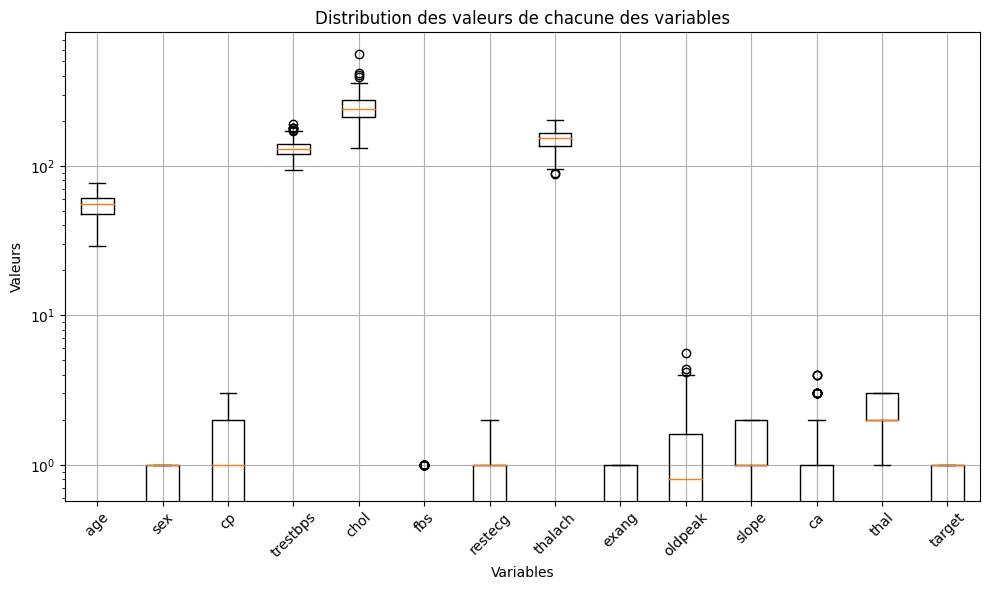

In [ ]:
import matplotlib.pyplot as plt


combined_data = np.column_stack((x_train, y_train))
combined_data_transposed = list(map(list, zip(*combined_data)))

# Création d'un "diagramme à moustache"
plt.figure(figsize=(10, 6))
plt.boxplot(combined_data_transposed, labels=headers[:-1] + ['target'])
plt.xticks(rotation=45)
plt.title('Distribution des valeurs de chacune des variables')
plt.xlabel('Variables')
plt.ylabel('Valeurs')
plt.yscale('log')  # Echelle logarithmique

plt.grid(True)
plt.tight_layout()
plt.show()